<a href="https://colab.research.google.com/github/datacommonsorg/api-python/blob/tutorials/Case_Study_Analyzing_Income_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2025 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 2.0.0

In [ ]:
# Install datacommons
!pip install "datacommons-client[Pandas]" --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.6 MB/s eta 0:00:00


# Analyzing Income Distribution

The American Community Survey (published by the US Census) annually reports the number of individuals in a given income bracket at the state level. We can use this information, stored in Data Commons, to visualize disparity in income for each state in the US. Our goal for this tutorial will be to generate a plot that visualizes the total number of individuals across a given set of income brackets for a given state.

Before we begin, we'll set up our notebook.

In [ ]:
# Import the Data Commons library
import datacommons_client

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

YOUR_API_KEY = "Replace this string with your API key"

dc_client = datacommons_client.DataCommonsClient(api_key=YOUR_API_KEY)


## 1. Getting the data

The Data Commons graph identifies 16 different income brackets. The list of these variable can be found under the **Economy > Household income** category the [Statistical Variable Explorer](https://datacommons.org/tools/statvar).

We can use the [`observations_dataframe`](https://docs.datacommons.org/api/python/v2/pandas.html) method to get a dataframe of values for each of the income brackets for each state in the US.

In [ ]:
# A list of income bracket statistical variables
income_brackets = [
                   "Count_Household_IncomeOfUpto10000USDollar",
                   "Count_Household_IncomeOf10000To14999USDollar",
                   "Count_Household_IncomeOf15000To19999USDollar",
                   "Count_Household_IncomeOf20000To24999USDollar",
                   "Count_Household_IncomeOf25000To29999USDollar",
                   "Count_Household_IncomeOf30000To34999USDollar",
                   "Count_Household_IncomeOf35000To39999USDollar",
                   "Count_Household_IncomeOf40000To44999USDollar",
                   "Count_Household_IncomeOf45000To49999USDollar",
                   "Count_Household_IncomeOf50000To59999USDollar",
                   "Count_Household_IncomeOf60000To74999USDollar",
                   "Count_Household_IncomeOf75000To99999USDollar",
                   "Count_Household_IncomeOf100000To124999USDollar",
                   "Count_Household_IncomeOf125000To149999USDollar",
                   "Count_Household_IncomeOf150000To199999USDollar",
                   "Count_Household_IncomeOf200000OrMoreUSDollar",
]

data = dc_client.observations_dataframe(variable_dcids=income_brackets, date='latest', entity_dcids='all', entity_type='State', parent_entity='country/USA')
data.head()

,date,entity,entity_name,variable,variable_name,value,facetId,importName,measurementMethod,observationPeriod,provenanceUrl,unit
0,2023,geoId/35,New Mexico,Count_Household_IncomeOf100000To124999USDollar,"Households With an Income Between $100,000 and...",73365,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
1,2023,geoId/40,Oklahoma,Count_Household_IncomeOf100000To124999USDollar,"Households With an Income Between $100,000 and...",147257,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
2,2023,geoId/10,Delaware,Count_Household_IncomeOf100000To124999USDollar,"Households With an Income Between $100,000 and...",41828,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
3,2023,geoId/15,Hawaii,Count_Household_IncomeOf100000To124999USDollar,"Households With an Income Between $100,000 and...",53322,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
4,2023,geoId/20,Kansas,Count_Household_IncomeOf100000To124999USDollar,"Households With an Income Between $100,000 and...",122949,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None


## 2. Analyzing the data

Let's plot our data as a histogram. Notice that the income ranges as tabulated by the US Census are not equal. At the low end, the range is 0-9999, whereas, towards the top, the range 150,000-199,999 is five times as broad! We will make the width of each of the columns correspond to their range, and will give us an idea of the total earnings, not just the number of people in that group.

First we provide code for generating the plot.

In [ ]:
# Bar chart endpoints (for calculating bar width)
label_to_range = {
  "Count_Household_IncomeOfUpto10000USDollar": [0, 9999],
  "Count_Household_IncomeOf10000To14999USDollar": [10000, 14999],
  "Count_Household_IncomeOf15000To19999USDollar": [15000, 19999],
  "Count_Household_IncomeOf20000To24999USDollar": [20000, 24999],
  "Count_Household_IncomeOf25000To29999USDollar": [25000, 29999],
  "Count_Household_IncomeOf30000To34999USDollar": [30000, 34999],
  "Count_Household_IncomeOf35000To39999USDollar": [35000, 39999],
  "Count_Household_IncomeOf40000To44999USDollar": [40000, 44999],
  "Count_Household_IncomeOf45000To49999USDollar": [45000, 49999],
  "Count_Household_IncomeOf50000To59999USDollar": [50000, 59999],
  "Count_Household_IncomeOf60000To74999USDollar": [60000, 74999],
  "Count_Household_IncomeOf75000To99999USDollar": [75000, 99999],
  "Count_Household_IncomeOf100000To124999USDollar": [100000, 124999],
  "Count_Household_IncomeOf125000To149999USDollar": [125000, 149999],
  "Count_Household_IncomeOf150000To199999USDollar": [150000, 199999],
  "Count_Household_IncomeOf200000OrMoreUSDollar": [200000, 300000],
}

def plot_income(data, state_name):
  # Assert that specified "state_name" is a valid state name
  frame_search = data.loc[data['entity_name'] == state_name].squeeze()
  if frame_search.shape[0] == 0:
    print('{} does not have sufficient income data to generate the plot!'.format(state_name))
    return

  # Print the resulting series
  data = frame_search.set_index('variable')['value']

  # Calculate the lengths without intervals
  widths_without_interval = []
  for bracket in income_brackets:
    r = label_to_range[bracket]
    widths_without_interval.append(int((r[1] - r[0]) / 18))

  # Calculate the x-axis positions
  pos, total = [], 0
  for l in widths_without_interval:
    pos.append(total + (l // 2))
    total += l

  # Calculate the bar lengths
  widths = []
  for bracket in income_brackets:
    r = label_to_range[bracket]
    # 50 here to be the intervals between bars
    widths.append(int((r[1] - r[0]) / 18 - 50))

  # Plot the histogram
  plt.figure(figsize=(12, 10))
  plt.xticks(pos, income_brackets, rotation=90)
  plt.grid(True)
  plt.bar(pos, data.values, widths, color='b', alpha=0.3)

  # Return the resulting frame.
  return frame_search

We can then call this code with a state to plot the income bracket sizes.

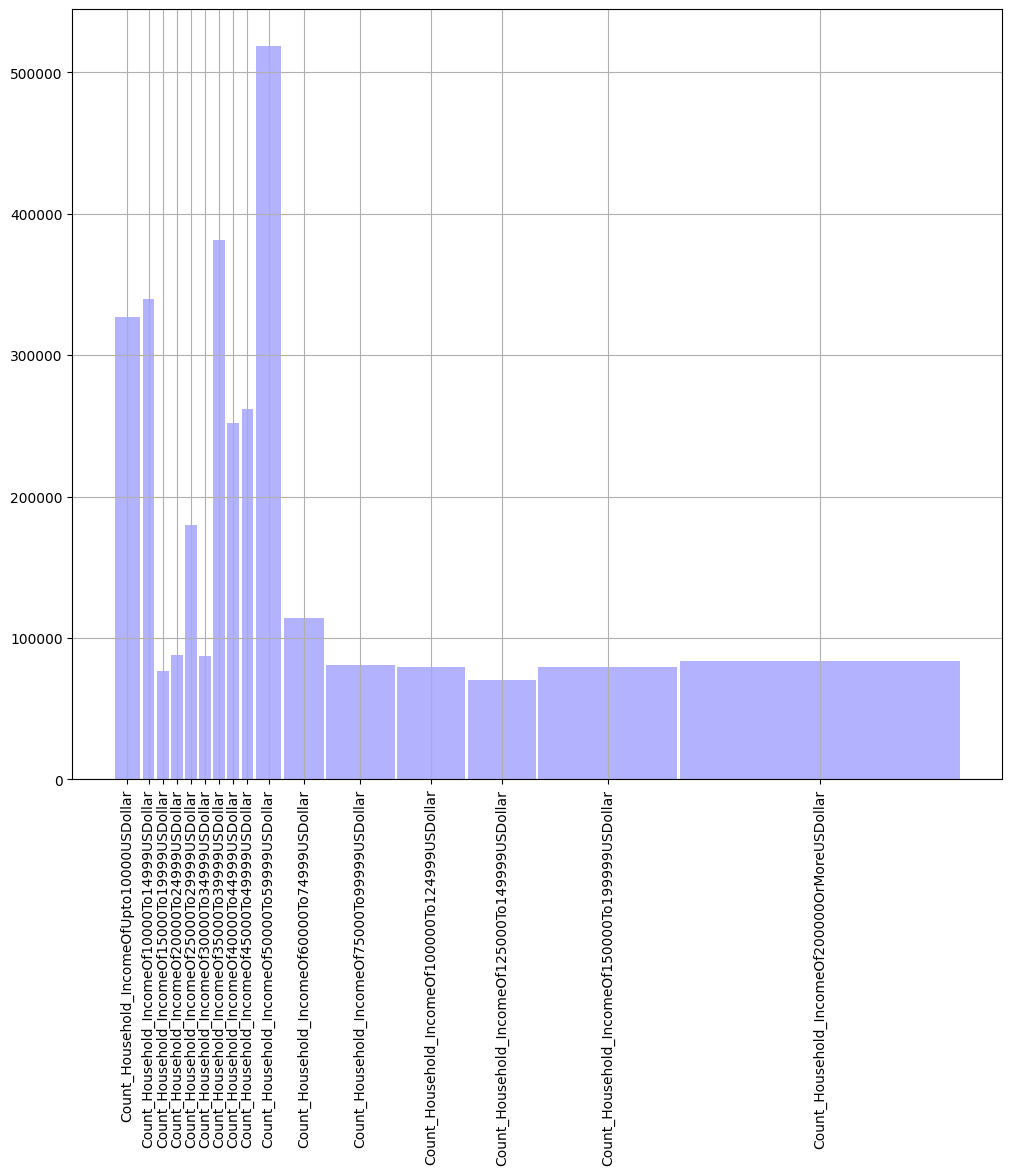

In [ ]:
#@title Enter state to plot { run: "auto" }
state_name = "Washington" #@param ["Missouri", "Arkansas", "Arizona", "Ohio", "Connecticut", "Vermont", "Illinois", "South Dakota", "Iowa", "Oklahoma", "Kansas", "Washington", "Oregon", "Hawaii", "Minnesota", "Idaho", "Alaska", "Colorado", "Delaware", "Alabama", "North Dakota", "Michigan", "California", "Indiana", "Kentucky", "Nebraska", "Louisiana", "New Jersey", "Rhode Island", "Utah", "Nevada", "South Carolina", "Wisconsin", "New York", "North Carolina", "New Hampshire", "Georgia", "Pennsylvania", "West Virginia", "Maine", "Mississippi", "Montana", "Tennessee", "New Mexico", "Massachusetts", "Wyoming", "Maryland", "Florida", "Texas", "Virginia"]
result = plot_income(data, state_name)

# Show the plot
plt.show()

and we can display the raw table of values.

In [ ]:
# Additionally print the table of income bracket sizes
result

,date,entity,entity_name,variable,variable_name,value,facetId,importName,measurementMethod,observationPeriod,provenanceUrl,unit
13,2023,geoId/53,Washington,Count_Household_IncomeOf100000To124999USDollar,"Households With an Income Between $100,000 and...",326847,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
88,2023,geoId/53,Washington,Count_Household_IncomeOf150000To199999USDollar,"Households With an Income Between $150,000 and...",339947,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
135,2023,geoId/53,Washington,Count_Household_IncomeOf20000To24999USDollar,"Households With an Income Between $20,000 and ...",76422,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
163,2023,geoId/53,Washington,Count_Household_IncomeOf45000To49999USDollar,"Count of Household: 45,000 - 49,999 USD",87812,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
254,2023,geoId/53,Washington,Count_Household_IncomeOf50000To59999USDollar,"Households With an Income Between $50,000 and ...",179819,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
267,2023,geoId/53,Washington,Count_Household_IncomeOf40000To44999USDollar,"Households With an Income Between $40,000 and ...",86987,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
352,2023,geoId/53,Washington,Count_Household_IncomeOf75000To99999USDollar,"Households With an Income Between $75,000 and ...",381522,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
377,2023,geoId/53,Washington,Count_Household_IncomeOf125000To149999USDollar,"Households With an Income Between $125,000 and...",252358,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
427,2023,geoId/53,Washington,Count_Household_IncomeOf60000To74999USDollar,"Households With an Income Between $60,000 and ...",261601,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
505,2023,geoId/53,Washington,Count_Household_IncomeOf200000OrMoreUSDollar,"Households With an Income of $200,000 or More",518785,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None


This is only the beginning! What else can you analyze? For example, you could try computing a measure of income disparity in each state (see [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient)).

You could then expand the dataframe to include more information and analyze how attributes like education level, crime, or even weather affect income disparity.

